# Summary

Evaluate a trained network on a [TIM barrel](https://pfam.xfam.org/clan/TIM_barrel) protein.

---

# Imports

In [1]:
%run _imports.ipynb

Setting the PACKAGE_VERSION environment variable.
Setting the DOCS_SECRET_KEY environment variable.
Setting the PYTHON_VERSION environment variable.
Setting the SPARK_MASTER environment variable.
Setting the SPARK_ARGS environment variable.
Setting the DB_TYPE environment variable.
Setting the DB_PORT environment variable.


2018-04-20 12:01:58.318040


In [2]:
import io
from typing import NamedTuple

import Bio.SeqIO
import torch

In [3]:
import kmtools.sequence_tools

In [4]:
import pagnn

# Parameters

In [5]:
NOTEBOOK_NAME = 'evaluate_tim_barrel'
NOTEBOOK_PATH = Path(NOTEBOOK_NAME).absolute()

NOTEBOOK_PATH.mkdir(parents=True, exist_ok=True)

In [6]:
DATABIN_PATH = Path(os.environ['DATABIN_DIR'])

In [7]:
PDB_ID = '1vkf'
PDB_PATH = NOTEBOOK_PATH.joinpath(PDB_ID + '.cif')

# Prepare dataset

## Extract sequence and adjacency from PDB

In [8]:
structure = kmbio.PDB.load(f'rcsb://{PDB_ID}.cif', structure_id=0)

In [9]:
from kmtools import structure_tools


def get_interaction_dataset(structure_file, R_CUTOFF):
    """Copied from "datapkg/pdb-analysis/notebooks/extract_pdb_interactions.ipynb"
    """
    try:
        structure = kmbio.PDB.load(structure_file, bioassembly_id=1, use_auth_id=False)
        bioassembly_id = 1
    except (kmbio.PDB.exceptions.BioassemblyError, KeyError) as e:
        logger.info("Could not construct bioassembly for file '%s'", structure_file)
        structure = kmbio.PDB.load(structure_file, bioassembly_id=0, use_auth_id=False)
        bioassembly_id = 0

    interactions = structure_tools.get_interactions(structure, r_cutoff=R_CUTOFF, interchain=True)
    interactions_core, interactions_interface = structure_tools.process_interactions(interactions)

    # Group interactions by chain / chan pair
    interactions_core_aggbychain = structure_tools.process_interactions_core(
        structure, interactions_core)
    interactions_interface_aggbychain = structure_tools.process_interactions_interface(
        structure, interactions_interface)

    # Drop duplicate rows?
    interactions_core, interactions_core_aggbychain = \
        structure_tools.drop_duplicates_core(interactions_core, interactions_core_aggbychain)
    interactions_interface, interactions_interface_aggbychain = \
        structure_tools.drop_duplicates_interface(interactions_interface,
                                                  interactions_interface_aggbychain)

    return (interactions_core, interactions_core_aggbychain, interactions_interface,
            interactions_interface_aggbychain, bioassembly_id)

In [10]:
kmbio.PDB.core.atom.logger.setLevel(logging.WARNING)

In [11]:
R_CUTOFF = 5

df = get_interaction_dataset(PDB_PATH, R_CUTOFF)

In [12]:
df[0].head()

,structure_id,model_id,chain_id,residue_idx_1,residue_idx_2,residue_id_1,residue_id_2,residue_name_1,residue_name_2,residue_aa_1,residue_aa_2
0,1VKF,0,A,0,1,13,14,MSE,PHE,None,F
1,1VKF,0,A,0,2,13,15,MSE,LYS,None,K
2,1VKF,0,A,0,21,13,34,MSE,VAL,None,V
3,1VKF,0,A,0,45,13,58,MSE,THR,None,T
4,1VKF,0,A,0,47,13,60,MSE,PHE,None,F


In [13]:
df[1]

,structure_id,model_id,chain_id,residue_pair,protein_sequence,protein_sequence_hash,residue_sequence,residue_pair_hash
0,1VKF,0,A,"((0, 1), (0, 2), (0, 21), (0, 45), (0, 47), (1, 0), (1, 2), (1, 3), (1, 5), (1, 21), (1, 23), (1, 47), (1, 93), (1, ...",MFKGIIAALWDMDSIGEIEPDVVFLLKSDILNLKFHLKILKDRGKTVFVDMDFVNGLGEGEEAILFVKKAGADGIITIKPKNYVVAKKNGIPAVLRFFALDSKAVERGIEQIETLG...,8D3E224A2D274C2D,"MSE,PHE,LYS,GLY,ILE,ILE,ALA,ALA,LEU,TRP,ASP,MSE,ASP,SER,ILE,GLY,GLU,ILE,GLU,PRO,ASP,VAL,VAL,PHE,LEU,LEU,LYS,SER,ASP,...",d67654dc933b6f3ad80e21a85a16b85c


In [14]:
adjacency_df = df[1].copy()

In [15]:
adjacency_df['residue_idx_1_corrected'] = pd.Series(
    adjacency_df['residue_pair'].apply(lambda lst: [t[0] for t in lst]))
adjacency_df['residue_idx_2_corrected'] = pd.Series(
    adjacency_df['residue_pair'].apply(lambda lst: [t[1] for t in lst]))

In [16]:
adjacency_df = adjacency_df.drop('residue_pair', axis=1)

In [17]:
adjacency_df.head()

,structure_id,model_id,chain_id,protein_sequence,protein_sequence_hash,residue_sequence,residue_pair_hash,residue_idx_1_corrected,residue_idx_2_corrected
0,1VKF,0,A,MFKGIIAALWDMDSIGEIEPDVVFLLKSDILNLKFHLKILKDRGKTVFVDMDFVNGLGEGEEAILFVKKAGADGIITIKPKNYVVAKKNGIPAVLRFFALDSKAVERGIEQIETLG...,8D3E224A2D274C2D,"MSE,PHE,LYS,GLY,ILE,ILE,ALA,ALA,LEU,TRP,ASP,MSE,ASP,SER,ILE,GLY,GLU,ILE,GLU,PRO,ASP,VAL,VAL,PHE,LEU,LEU,LYS,SER,ASP,...",d67654dc933b6f3ad80e21a85a16b85c,"[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4...","[1, 2, 21, 45, 47, 0, 2, 3, 5, 21, 23, 47, 93, 118, 138, 140, 159, 160, 0, 1, 3, 4, 155, 158, 159, 160, 1, 2, 4, 5, ..."


In [18]:
pq.write_table(
    pa.Table.from_pandas(
        adjacency_df.rename(columns={
            'protein_sequence': 'sequence',
            'residue_idx_1_corrected': 'adjacency_idx_1',
            'residue_idx_2_corrected': 'adjacency_idx_2',
        }),
        preserve_index=False,
    ),
    NOTEBOOK_PATH.joinpath(f'{PDB_ID}_adjacencies.parquet'),
    version='2.0', flavor='spark'
)

# Load network

In [19]:
import torch

In [20]:
from typing import NamedTuple

class Args(NamedTuple):
    hidden_size: int = 64

args = Args()

In [21]:
net_d = pagnn.models.AESeqAdjApplyExtra(
    'discriminator', hidden_size=args.hidden_size, bottleneck_size=1)
net_g = pagnn.models.AESeqAdjApplyExtra(
    'generator', hidden_size=args.hidden_size, bottleneck_size=16, encoder_network=net_d)

In [22]:
step = 6600

checkpoint_path = NOTEBOOK_PATH.parent / 'train_neural_network' / 'gan-permute-seq-0-test_x12-0.1.9.dev-4a07eef'
checkpoint_path

with checkpoint_path.joinpath('checkpoints').joinpath(f'checkpoint-step{step}.json').open('rt') as fin:
    checkpoint = json.load(fin)

In [23]:
checkpoint

{'net_d_path_name': 'net_d-step_6600.model',
 'net_g_path_name': 'net_g-step_6600.model',
 'step': 6600,
 'unique_name': 'gan-permute-seq-0-test_x12-0.1.9.dev-4a07eef'}

In [24]:
net_g.load_state_dict(
    torch.load(checkpoint_path.joinpath('models').joinpath(checkpoint['net_g_path_name']).as_posix()))

In [25]:
net_d.load_state_dict(
    torch.load(checkpoint_path.joinpath('models').joinpath(checkpoint['net_d_path_name']).as_posix()))

In [26]:
net_d = net_d.cuda()
net_g = net_g.cuda()

In [27]:
net_g.eval()
assert not net_g.training

net_d.eval()
assert not net_d.training

# Load dataset

In [28]:
rowgen = pagnn.io.iter_datarows(
    NOTEBOOK_PATH.joinpath(f'{PDB_ID}_adjacencies.parquet'),
    columns={
        'protein_sequence': 'sequence',
        'residue_idx_1_corrected': 'adjacency_idx_1',
        'residue_idx_2_corrected': 'adjacency_idx_2',
    }
)
rowgen = list(rowgen)

In [29]:
dataset = pagnn.dataset.row_to_dataset(rowgen[0], target=1)
dataset = pagnn.dataset.to_gan(dataset)

In [30]:
dataset

DataSetGAN(seqs=[b'MFKGIIAALWDMDSIGEIEPDVVFLLKSDILNLKFHLKILKDRGKTVFVDMDFVNGLGEGEEAILFVKKAGADGIITIKPKNYVVAKKNGIPAVLRFFALDSKAVERGIEQIETLGVDVVEVLPGAVAPKVARKIPGRTVIAAGLVETEEEAREILKHVSAISTSSRILWKM'], adjs=[<172x172 sparse matrix of type '<class 'numpy.int16'>'
	with 1756 stored elements in COOrdinate format>], targets=[1], meta=None)

# Generate sequences

In [77]:
from torch.autograd import Variable
import torch.nn.functional as F

In [78]:
datavar = net_d.dataset_to_datavar(dataset)

In [79]:
seqs, adjs = datavar
adjs = [adjs]

In [80]:
import pagnn.training.gan.helpers

In [81]:
batch_size = 256
n_seqs = 1000

target = torch.cat([datavar.seqs[0, :, :].data] * batch_size, 1)
noise = pagnn.training.gan.helpers.generate_noise(net_g, adjs * batch_size)

blosum62_scores = []
edit_scores = []
best_blosum62_scores = []
best_edit_scores = []
best_sequences = []
best_idxs = []

min_length = 11  # adjs[0][4].shape[1]

for _ in tqdm.tqdm_notebook(range(n_seqs), total=n_seqs):
    noisev = noise.normal_(0, 1)
    with torch.no_grad():
        fake_seq = net_g(noisev, adjs * batch_size).data
        fake_pred = net_d(fake_seq, adjs * batch_size)
        # Not sure why, but seems to work this way...
        assert fake_pred.shape[2] == ((adjs[0][4].shape[1] * batch_size) / 4 + 1)

    fake_seq_onehot = pagnn.utils.argmax_onehot(fake_seq)

    blosum62_scores.append(pagnn.utils.score_blosum62(target, fake_seq_onehot))
    edit_scores.append(pagnn.utils.score_edit(target, fake_seq_onehot))

    best_score = None
    for i, start in enumerate(range(0, fake_seq_onehot.shape[2], datavar.seqs.shape[2])):
        stop = start + datavar.seqs.shape[2]
        score = fake_pred[:, :, min_length * i // 4: min_length * (i + 1) // 4]
        assert score.shape[2] in [min_length // 4, min_length // 4 + 1]
        score = F.sigmoid(score).mean()

        if best_score is None or score > best_score:
            best_score = score
            best_idx = i
            
            fake_seq_slice = fake_seq_onehot[:, :, start:stop]

            best_blosum62_score = pagnn.utils.score_blosum62(datavar.seqs.data, fake_seq_slice)
            best_edit_score = pagnn.utils.score_edit(datavar.seqs.data, fake_seq_slice)
            best_sequence = ''.join(
                pagnn.AMINO_ACIDS[int(i)] 
                for i in np.argmax(pagnn.to_numpy(fake_seq_slice), 1)[0])

        start = stop
    assert i == (batch_size - 1)
    best_blosum62_scores.append(best_blosum62_score)
    best_edit_scores.append(best_edit_score)
    best_sequences.append(best_sequence)
    best_idxs.append(best_idx)

HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

KeyboardInterrupt: 

In [51]:
len(best_sequences)

100

In [52]:
len(set(best_sequences))

100

In [53]:
assert (len(seq) == len(best_sequences[0]) for seq in best_sequences)

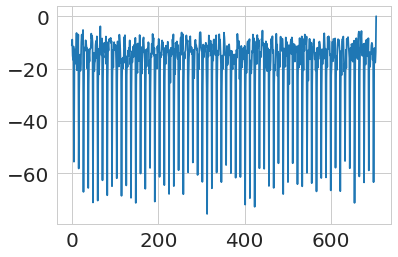

In [54]:
plt.plot(pagnn.to_numpy(fake_pred).squeeze())

(array([10.,  6., 16., 24., 14., 13.,  8.,  4.,  3.,  2.]),
 array([-9.94999981, -9.43499985, -8.91999989, -8.40499992, -7.88999996,
        -7.375     , -6.86000004, -6.34500008, -5.83000011, -5.31500015,
        -4.80000019]),
 <a list of 10 Patch objects>)

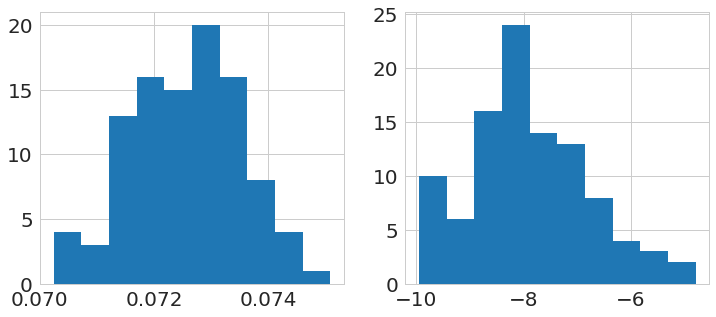

In [55]:
# Edit scores
fg, axs = plt.subplots(1, 2, figsize=(12, 5))

plt.sca(axs[0])
plt.hist(edit_scores)

plt.sca(axs[1])
plt.hist(best_edit_scores)

(array([10.,  6., 16., 24., 14., 13.,  8.,  4.,  3.,  2.]),
 array([-9.94999981, -9.43499985, -8.91999989, -8.40499992, -7.88999996,
        -7.375     , -6.86000004, -6.34500008, -5.83000011, -5.31500015,
        -4.80000019]),
 <a list of 10 Patch objects>)

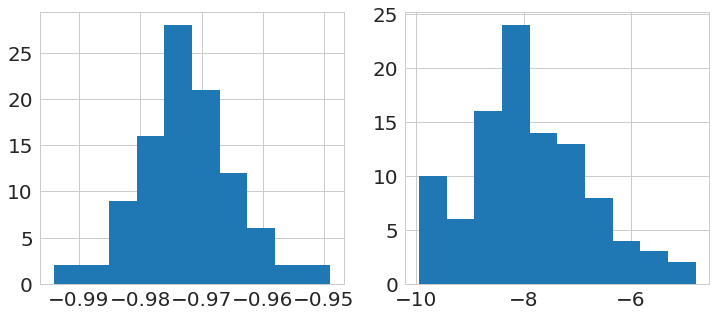

In [56]:
# BLOSUM62 scores
fg, axs = plt.subplots(1, 2, figsize=(12, 5))

plt.sca(axs[0])
plt.hist(blosum62_scores)

plt.sca(axs[1])
plt.hist(best_blosum62_scores)

In [ ]:
# importlib.reload(kmtools.sequence_tools.psipred)

In [61]:
tmp_folder = Path('/dev/shm/strokach/tmp')
tmp_folder.mkdir(parents=True, exist_ok=True)

def worker(input_):
    i, seq = input_
    fasta_file = tmp_folder.joinpath(f'seq_{i}.fasta')
    with fasta_file.open('wt') as fout:
        fout.write(f'> seq_{i}\n')
        fout.write(seq + '\n')
    psipred_file = kmtools.sequence_tools.run_psipred(fasta_file)
    psipred = kmtools.sequence_tools.read_psipred(psipred_file)
    return psipred


# Reference
psipred_ref = worker(('x', dataset.seqs[0].decode()))
print(psipred_ref)


# Actual
psipreds = []
seqs_per_chunk = 100
for i in range(0, len(best_sequences), seqs_per_chunk):
    with concurrent.futures.ProcessPoolExecutor() as p:
        psipreds_chunk = p.map(worker, list(enumerate(best_sequences[i, i+seqs_per_chunk])))
        psipreds_chunk = list(psipreds_chunk)
        psipreds.extend(psipreds_chunk)
    
shutil.rmtree(tmp_folder)

CCCCEEEECCCHHHHHHCCCCEEEEECCCHHHHHHHHHHHHHCCCEEEEEEHHCCCCCCCHHHHHHHHHCCCCEEEECCHHHHHHHHHCCCEEEEEEEECCHHHHHHHHHHHHCCCCCEEEECCHHHHHHHHHHHCCCCEEEECCCCCHHHHHHHHHHCCEEECCCHHHHCC


In [63]:
psipreds = list(psipreds)

In [64]:
assert len(psipreds) == len(best_sequences)

In [65]:
psipred_scores = [
    sum((a == b) for a, b in zip(psipreds[i], psipred_ref)) / len(psipred_ref)
    for i in range(len(psipreds))
]

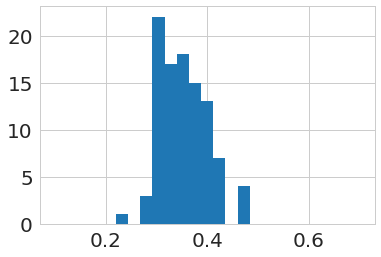

In [75]:
_ = plt.hist(psipred_scores, range=(0.1, 0.7), bins=25)

In [76]:
len(psipred_scores)

100

In [ ]:
np.argmax(pagnn.to_numpy(fake_seq_onehot), 1)[0]

In [ ]:
''.join(pagnn.AMINO_ACIDS[int(i)] for i in np.argmax(pagnn.to_numpy(fake_seq_onehot), 1)[0])

In [ ]:
fake_seq_onehot

In [ ]:
blosum62_score

In [ ]:
edit_score

# Compare `psipred` predictions

In [ ]:
name = PDB_ID + '0' + 'A'
fasta_file = NOTEBOOK_PATH.joinpath(f'{name}.fasta')

with fasta_file.open('wt') as fout:
    fout.write(dedent(f"""\
    > {name}
    {dataset[0].seq.decode()}
    """))

In [ ]:
fasta_withss_file = kmtools.sequence_tools.run_psipred(fasta_file)
psipred = kmtools.sequence_tools.read_psipred(fasta_withss_file)
psipred

In [ ]:
pagnn.utils.make_weblogo(
    [str(psipred.seq), ], units='probability', color_scheme='Hydrophobicity', stacks_per_line=40,
)